# 0 Description
**0.1 Data Description**
Three types of data were recorded in London between November 2011 and February 2014
* Electricity consumption, 5,567 households, half-hour resolution
* Weather factors and a verbal description, in 1 hour resolution + a general label for the whole day
* Calendar information: time of day, day of year, weekday/weekend/holiday
* Information about households: 
[more details](https://www.kaggle.com/jeanmidev/smart-meters-in-london?select=weather_hourly_darksky.csv)

**0.2 Weather Data Description**
Features recorded in 1 hour resolution:
* wind bearing: wind angle between 0 and 360 degrees
* temperature
* pressure
* wind speed
* humidity
* dew point
* precipitation type: either rain or snow
* apparent temperature
* visibility
* icon, summary:  verbal description of the weather condition

**0.3 Introducing Temporal Features**

Extracted temporal features:
* Hour of day (0 to 23)
* Month of year (1 to 12)
* Day of year (0 to 364)

Encoding features on unit circle:
* Problem: month 1 and 12 are as similar as 1 and 2 
* Solution: assign 12 equally-distanced points on the unit circleto the months
* Add two features; e.g. for month of year: monthofyx=cos(2πmonthofy/12),monthofyy=sin(2πmonthofy/12)
* Same holds for hour of day and day of year

In [8]:
#Library importing
import math
import pylab as pl
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib as mpl
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from load_data import get_data_of_a_person, find_building

# 1. Load Consumption Data
In this section, we load and clean the data of a single household.

**1.1 Selecting a Building:** For the purpose of a good representation, we look for a building that has:
* at least 2 years of data over 2012 and 2013
* no time interval during which the house was completely empty, either because of travel or changing the tenants

The household can be selected by command find_building(block_number), where the input is the file index to look for a household. In the following, we selected a household from block 77 and will perform the visualization and data analysis on his dataset.

In [2]:
# Select a house from block 77
#block, house_id = find_building([77])
block=5
house_id = "MAC004504"

**1.2 Cleaning Data**
To get started, we need to load and clean the data. The following steps are executed:
* load the consumption data for the selected household
* load the weather data for London 
* remove missing values of both datasets by interpolation
* combine the two datasets
* extract additional temporal features such as the season, time of the day, whether it was a holiday or not, ...
* normalize all features using min-max scaler to -1 and 1

These operations are implemented in the 'get_data_of_a_person' function, where the inputs 'block' and 'house_id' are used to find the household and 'verbose' sets if the additional information must be printed. The function returns a dataframe for the specified household, where each row corresponds to a 30-minutes time interval and each row is a feature.

In [4]:
df_1p = get_data_of_a_person(block=block, house_id=house_id, verbose=True)

Data starts at 
2011-12-19
and ends at
2014-02-28

Only considering data collected from 
2012-01-01
 to 
2013-12-31

Data has missing row in
2012-02-08
[15.]
2012-05-25
[16.]
2012-05-28
[10.5 11.  11.5]
2013-03-12
[19.]
2013-07-10
[19.]
Added row for missing time steps

Duplicate rows:
       energy        date  hourofd
16927     NaN  2012-12-18     15.0

All days have 48 records
number of holidays
25.0
Hourly features:
visibility
windBearing
temperature
time
dewPoint
pressure
apparentTemperature
windSpeed
precipType
icon
humidity
summary

Check for missing dates in the hourly data:

Data has missing row in
2013-09-09
[23]
2013-09-10
[0]
Added row for missing time steps

Hourly weather contains 4 NaNs in rows:
       temperature icon        date  hourofd
14831          NaN  NaN  2013-09-09       23
14832          NaN  NaN  2013-09-10        0
Hourly weather nans were interpolated

Daily features:
temperatureMax
temperatureMaxTime
windBearing
icon
dewPoint
temperatureMinTime
cloudCover


**1.3 List of Features**
Once the dataframe is formed, the following features are returned as the columns:
* energy: electricity consumption in the interval measured in KwH
* date: date of data collection
* hourofd, hourofd_x, hourofd_y: hour of day, sin and cos transfers
* weekday
* flag_weekend, flg_holiday, day_type: if it was a weekday, weekend, or holiday
* dayofy, dayofy_x, dayofy_y: number of days past since the beginning of the year, sin and cos transforms
* daypart: morning, noon, afternoon, evening, or night (derived from hour of day).
* month  
* season   
* temperature_hourly: temperature          
* icon_hourly, icon_daily: a general description about the weather provided in the dataset

In [6]:
print(df_1p.head())

   energy        date  hourofd  hourofd_x  hourofd_y weekday  flag_weekend  \
0   1.254  2012-01-01      0.0   0.000000   1.000000  Sunday          True   
1   1.046  2012-01-01      0.5   0.130526   0.991445  Sunday          True   
2   1.010  2012-01-01      1.0   0.258819   0.965926  Sunday          True   
3   0.904  2012-01-01      1.5   0.382683   0.923880  Sunday          True   
4   0.746  2012-01-01      2.0   0.500000   0.866025  Sunday          True   

   dayofy  dayofy_x  dayofy_y daypart  month  season  flg_holiday day_type  \
0     0.0       0.0       1.0   night      1  winter        False  weekend   
1     0.0       0.0       1.0   night      1  winter        False  weekend   
2     0.0       0.0       1.0   night      1  winter        False  weekend   
3     0.0       0.0       1.0   night      1  winter        False  weekend   
4     0.0       0.0       1.0   night      1  winter        False  weekend   

  temperature_hourly          icon_hourly         icon_daily  

# 2 Visualizing Consumption  Data
**2.1 Plot one year of data**
The electricity consumption data is plotted versus time, where each row shows one month, each column shows a time interval in that month. Brighter colors mark higher consumptions.

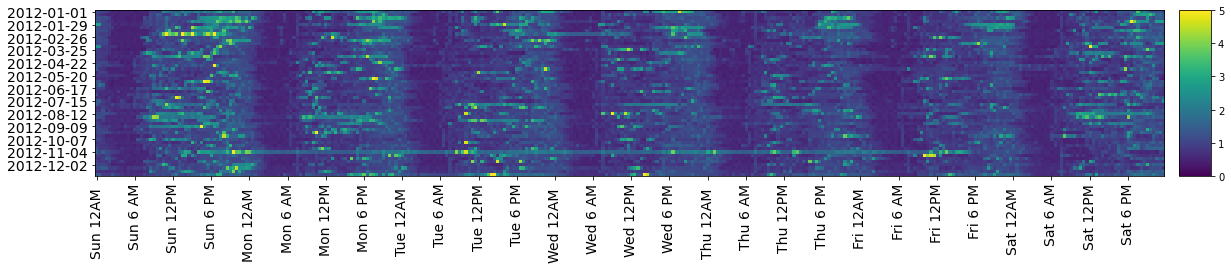

In [9]:
num_weeks = 52
data = df_1p.energy.iloc[0:num_weeks*7*48].values
data = data.reshape(52,48*7)

yTickLabels = pd.DataFrame(data = pd.date_range(start = '2012-01-01', end = '2012-12-29', freq = '4W'), columns=['datetime'])
yTickLabels['date'] = yTickLabels['datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))

s1 = ['Sun ', 'Mon ', 'Tue ', 'Wed ', 'Thu ', 'Fri ', 'Sat ']
s2 = ['12AM ', '6 AM', '12PM', '6 PM']
s1 = np.repeat(s1, 4)
s2 = np.tile(s2, 7)
xTickLabels = np.char.add(s1, s2)

fig = plt.figure(figsize=(20,30))
ax = plt.gca()
im = ax.imshow(data, vmin =0, vmax = 5, interpolation='nearest', origin='upper')
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ax.set_yticks(range(0,num_weeks,4))
ax.set_yticklabels(labels = yTickLabels['date'], fontsize = 14)

ax.set_xticks(range(0,168*2,12))
ax.set_xticklabels(labels = xTickLabels, fontsize = 14, rotation = 90)

plt.colorbar(im, cax=cax)

**2.2 Box Plots**
For a better visualiztion of the consumption pattern over one day, we display box-plots of the consumption vs. the hour of the day. We expect the pattern to be different among weekdays, weekends, and holidays, thus, three box plots are produced. 

Observations:
* The results confirm our intuition of having different consumption patterns in weekdays, weekends, and holidays
* The data has many outliers

Next, we also plot box plots vs. other variables to explore the effects.

Text(0.5, 1.0, 'Weather Condition Box Plot')

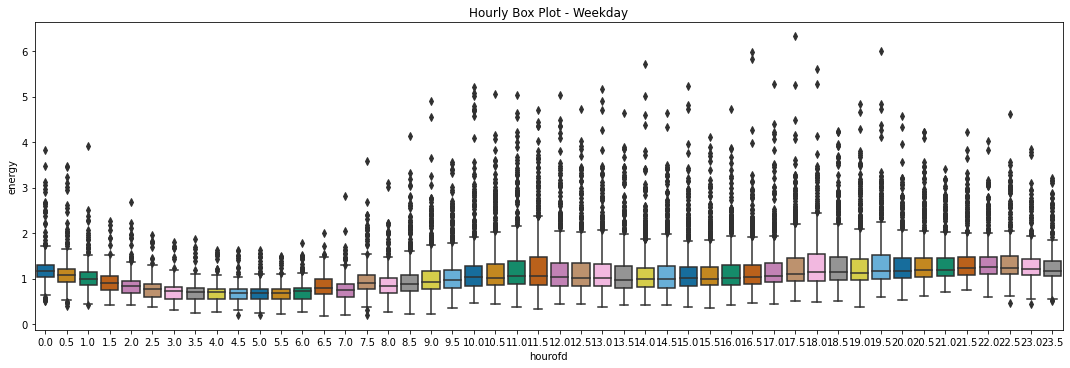

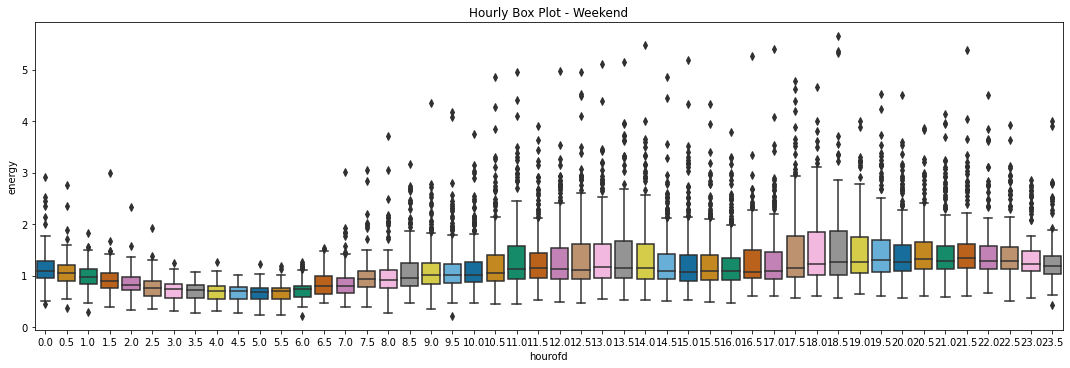

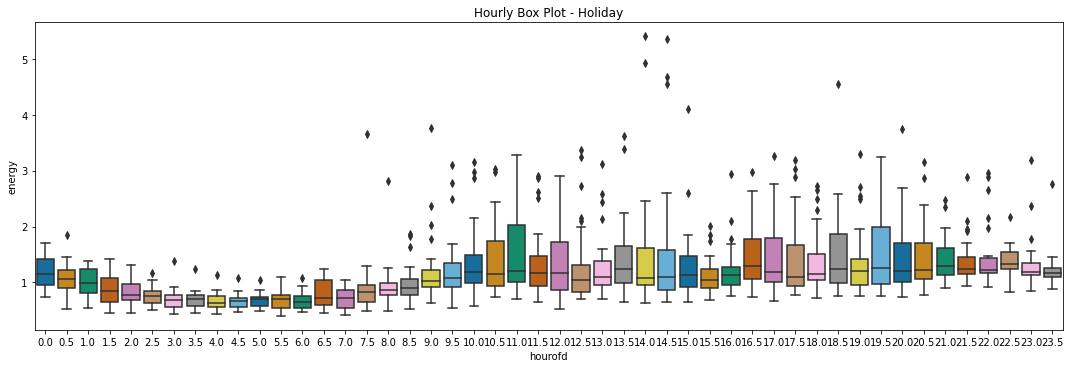

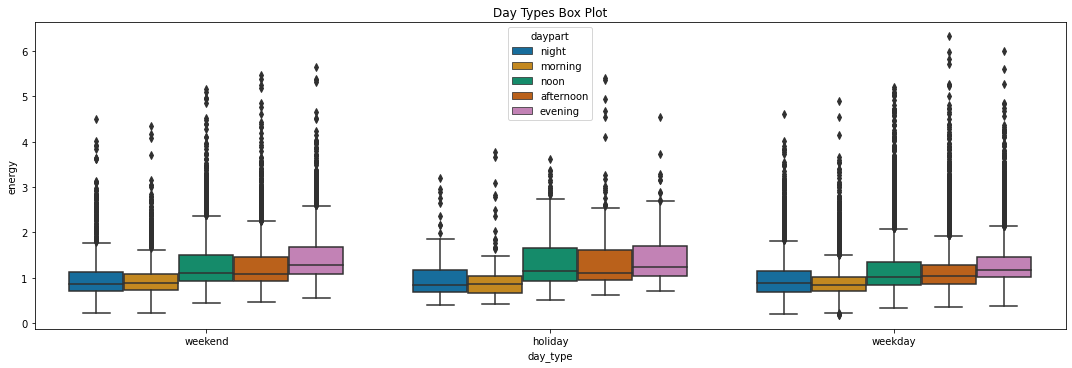

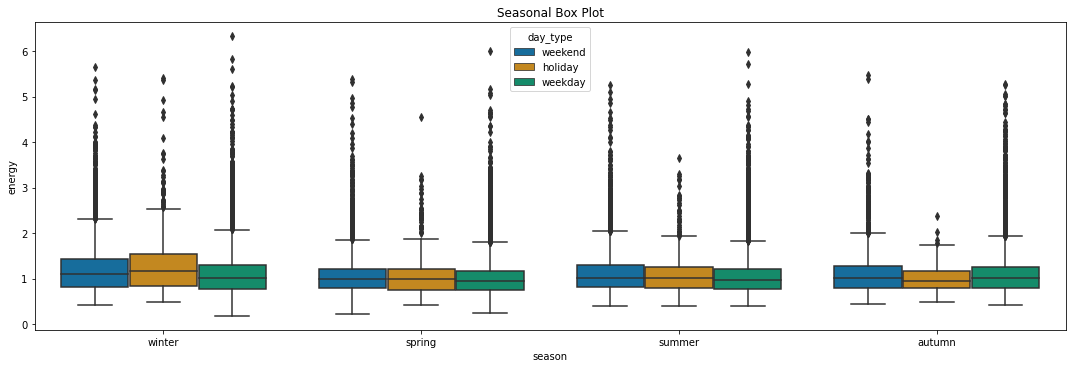

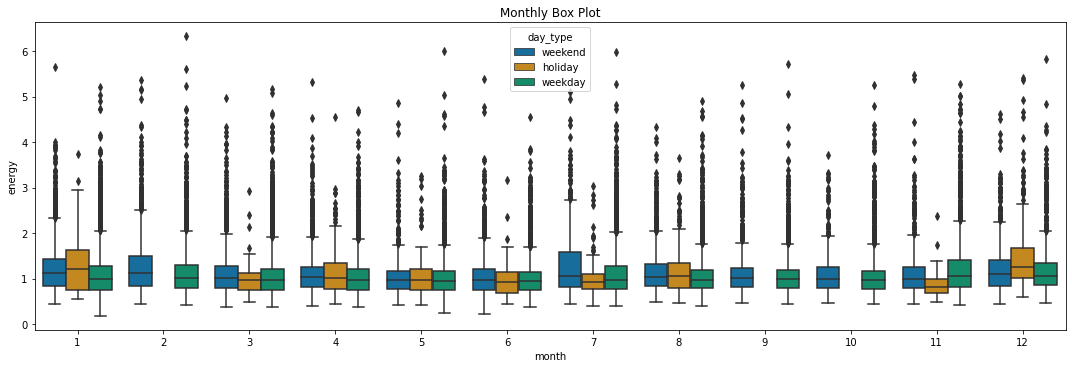

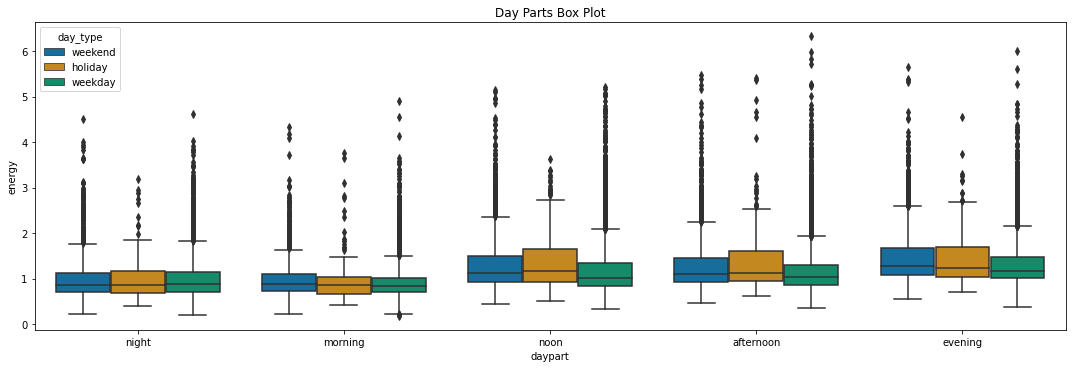

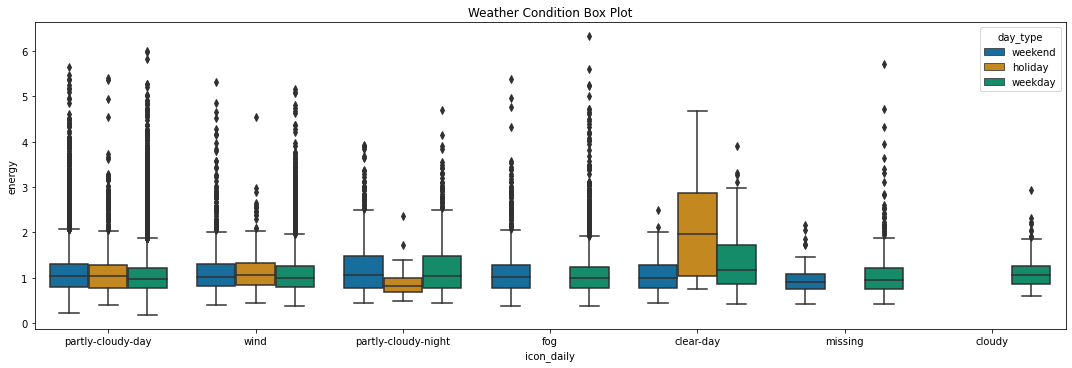

In [10]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(y='energy', x='hourofd', data=df_1p[df_1p.day_type=='weekday'], 
            palette="colorblind", 
            ax=ax)
plt.tight_layout()
ax.set_title('Hourly Box Plot - Weekday')

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(y='energy', x='hourofd', data=df_1p[df_1p.day_type=='weekend'], 
            palette="colorblind", 
            ax=ax)
plt.tight_layout()
ax.set_title('Hourly Box Plot - Weekend')

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(y='energy', x='hourofd', data=df_1p[df_1p.day_type=='holiday'], 
            palette="colorblind", 
            ax=ax)
plt.tight_layout()
ax.set_title('Hourly Box Plot - Holiday')

######

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(y='energy', x='day_type', data=df_1p, 
            palette="colorblind",hue='daypart', 
            ax=ax)
plt.tight_layout()
ax.set_title('Day Types Box Plot')

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(y='energy', x='season', data=df_1p, 
            palette="colorblind",hue='day_type', 
            ax=ax)
plt.tight_layout()
ax.set_title('Seasonal Box Plot')

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(y='energy', x='month', data=df_1p, 
            palette="colorblind",hue='day_type', 
            ax=ax)
plt.tight_layout()
ax.set_title('Monthly Box Plot')

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(y='energy', x='daypart', data=df_1p, 
            palette="colorblind",hue='day_type', 
            ax=ax)
plt.tight_layout()
ax.set_title('Day Parts Box Plot')

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(y='energy', x='icon_daily', data=df_1p, 
            palette="colorblind",hue='day_type', 
            ax=ax)
plt.tight_layout()
ax.set_title('Weather Condition Box Plot')

# 3.Autocorrelation plots:
**3.1 ACF:** Autocorrelation with confidence bounds


**3.2 PACF:** The partial autocorrelation function (PACF) plot shows the amount of autocorrelation at lag k that is not explained by lower-order autocorrelations
– The partial autocorrelation at lag k is the coefficient of LAG(Y,k) in an AR(k) model, i.e., in a regression of Y on LAG(Y, 1), LAG(Y,2), ... up to LAG(Y,k)

Observations:
* high correlation with 1 hour ago (2 samples)
* picks at 7, 14, and 21 days => weekly pattern

Plot suggests that the following time steps are relevant:
* 2 previous samples, energy[t-1] and energy[t-2]
* yesterday the same time and 1 step before, energy[t-48] and energy[t-49]
* previous week the same time and 1 step before, energy[t-48*7] and energy[t-48*7-1]


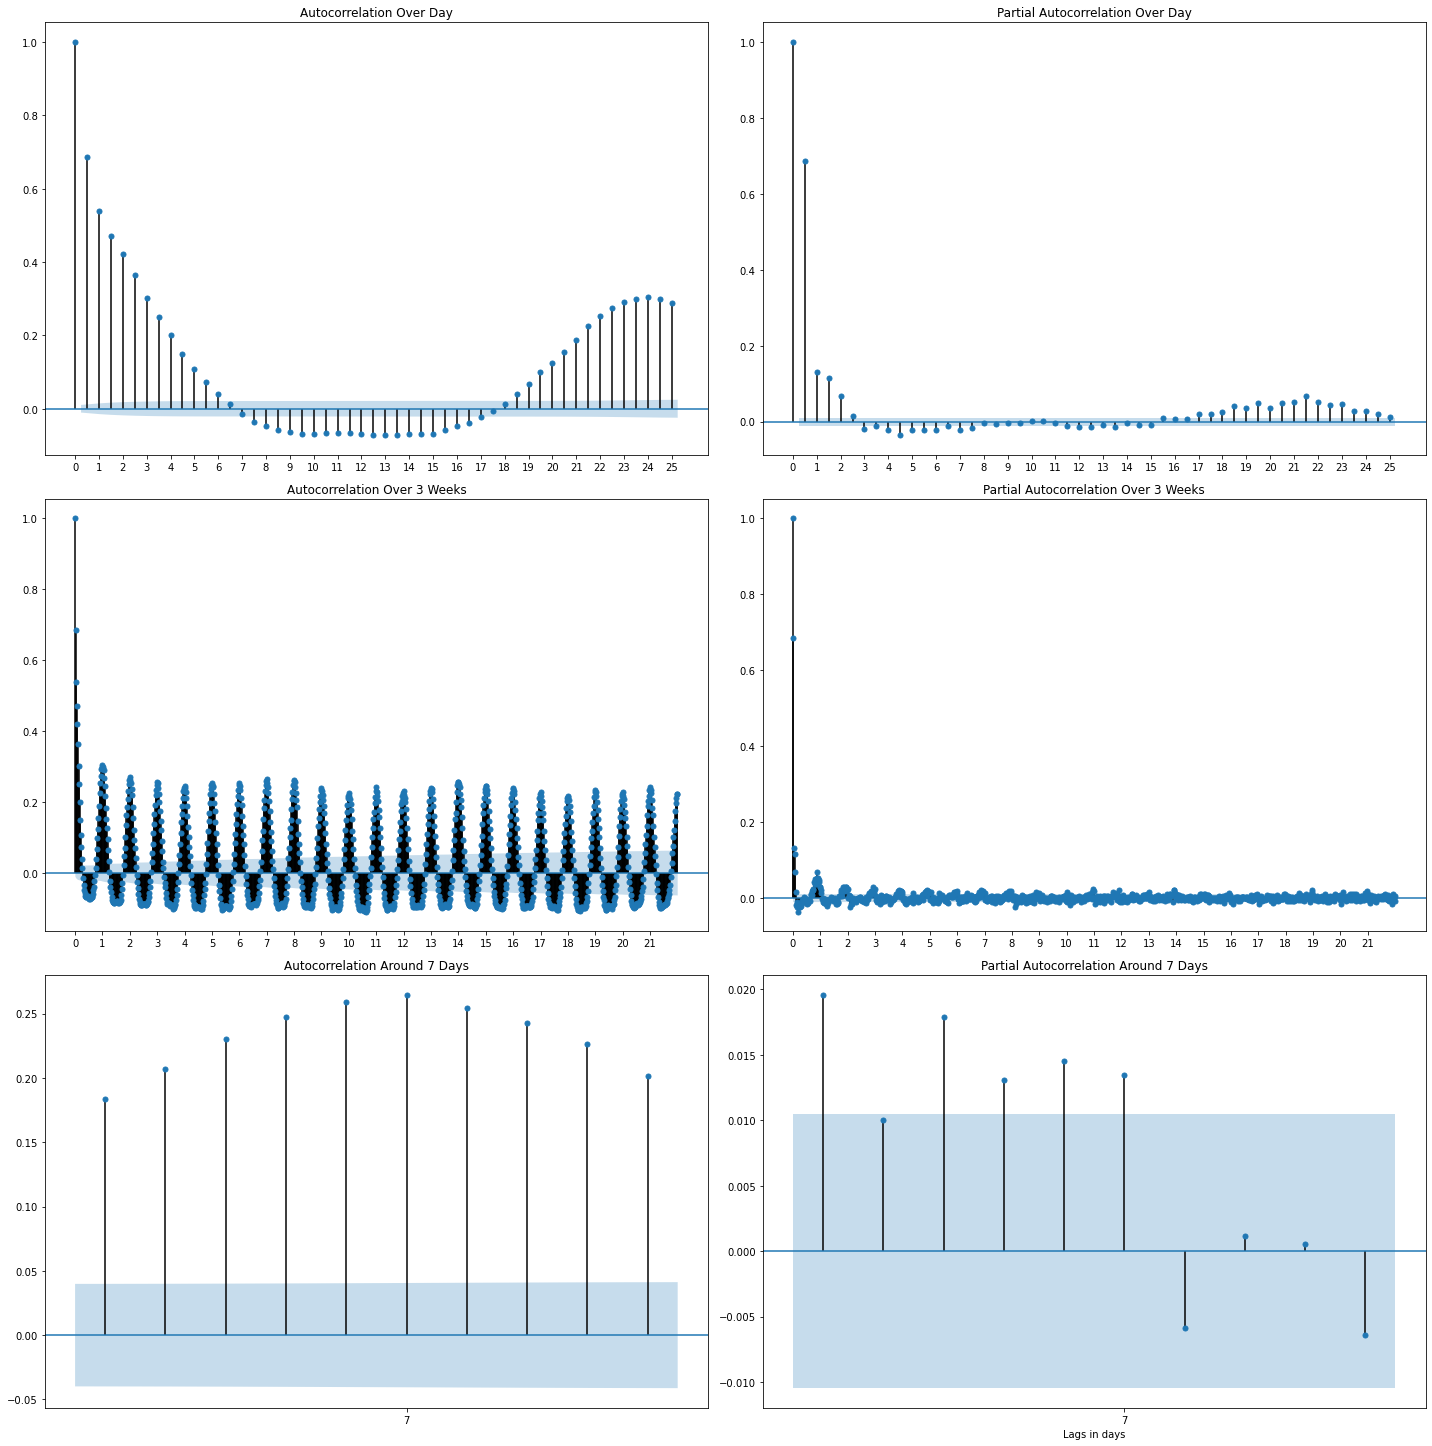

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(20,20))

# Autocorrelation over day
plot_acf(df_1p.energy, lags=25*2, ax=axs[0,0], title='Autocorrelation Over Day')
plot_pacf(df_1p.energy, lags=25*2, ax=axs[0,1], title='Partial Autocorrelation Over Day')
axs[0,0].set_xticks(np.arange(26)*2)
axs[0,0].set_xticklabels(np.arange(26))
axs[0,1].set_xticks(np.arange(26)*2)
axs[0,1].set_xticklabels(np.arange(26))

# over 3 weeks
n_days=22
plot_acf(df_1p.energy, lags=24*n_days*2, ax=axs[1,0], title='Autocorrelation Over 3 Weeks')
plot_pacf(df_1p.energy, lags=24*n_days*2, ax=axs[1,1], title='Partial Autocorrelation Over 3 Weeks')
axs[1,0].set_xticks(np.arange(n_days)*48)
axs[1,0].set_xticklabels(np.arange(n_days))
axs[1,1].set_xticks(np.arange(n_days)*48)
axs[1,1].set_xticklabels(np.arange(n_days))

# zoom
plot_acf(df_1p.energy, lags=np.arange(7*48-5,7*48+5), ax=axs[2,0], title='Autocorrelation Around 7 Days')
plot_pacf(df_1p.energy, lags=np.arange(7*48-5,7*48+5), ax=axs[2,1], title='Partial Autocorrelation Around 7 Days')
axs[2,0].set_xticks([7*48])
axs[2,0].set_xticklabels([7])
axs[2,1].set_xticks([7*48])
axs[2,1].set_xticklabels([7])



plt.tight_layout()
plt.xlabel('Lags in days')
plt.show()